In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
f = open("../names.txt", "r")
words = f.read().splitlines()
words[:8]
len(words)
f.close()

In [ ]:
# build vocab of chars and map to/from ints
alphabet = sorted(list(set(''.join(words))))
alphabet.insert(0, '.')
stoi = {s:i for i, s in enumerate(alphabet)}
itos = {i:s for s, i in stoi.items()}

In [219]:
# build training set
block_size = 4
# list holding context at every point
X = []
# list holding all "desired outputs"/labels(next char) for every context
Y = []

for w in words:
    # current word were on
    #print(w)
    # int value for the char in context(starts with 0's aka .'s)
    context = [0] * block_size
    # for every char in word + end char
    for ch in w + '.':
        # get numeric representation of character
        ix = stoi[ch]
        #add context to X
        X.append(context)
        # add next char(label) to Y
        Y.append(ix)
        # print the current context and then the next char(label)
     #   print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [220]:
# new build dataset, using different training splits ?

def build_dataset(words):
    block_size = 4
    # list holding context at every point
    X = []
    # list holding all "desired outputs"/labels(next char) for every context
    Y = []
    
    for w in words:
        # int value for the char in context(starts with 0's aka .'s)
        context = [0] * block_size
        # for every char in word + end char
        for ch in w + '.':
            # get numeric representation of character
            ix = stoi[ch]
            #add context to X
            X.append(context)
            # add next char(label) to Y
            Y.append(ix)
            # shift context window over to the right
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
# mix up words
random.shuffle(words)
# get numeric bounds at 80% of set and 90% if set so training set can be split up in 80 10 10
n1 = int(.8*len(words))
n2 = int(.9*len(words))
# create different training splits
Xtr, Ytr = build_dataset(words[0:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

torch.Size([182484, 4]) torch.Size([182484])
torch.Size([22869, 4]) torch.Size([22869])
torch.Size([22793, 4]) torch.Size([22793])


In [113]:
# creating lookup table
C = torch.randn((27,2))
X.shape, C.shape

(torch.Size([228146, 4]), torch.Size([27, 2]))

In [ ]:
# creating embeddings
# for every entry in X(a 0-27 int) this will map its corresponding embedding(a 2d vector)
emb = C[X]

In [ ]:
# creating weights?
#               inputs  neurons
W1 = torch.randn((6,     100))
b1 = torch.randn(100)

In [ ]:
# works bc .view derives -1 as the size needed for it to be equivalenet using 6, so the
# x by 3 by 2 arr becomes x by 6, which can be multiplied by W, which is 6 by x
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
# hidden layer output, fed into next layer which gives 27 outputs bc there are 27 possible chars, so those
# will be normalized into 27 different probabilities
h

In [ ]:
logits = h @ W2 + b2
logits.shape


In [ ]:
# softmax function
# the "counts" of every next char, which will be summed and normalized
counts = logits.exp()
# get probabilities of every next char, by summing all the "counts" in every row and dividing each entry in row by that sum
prob = counts / counts.sum(1, keepdims=True)

In [200]:
# everything above(the parameter creation), but organized
g = torch.Generator().manual_seed(2147483647)
# lookup table, the mapping of every int representation of char to a 2d vector
C = torch.randn(27, 15, generator=g)
# weights and biases
W1 = torch.randn(60, 250, generator=g)
b1 = torch.randn(250, generator=g)
W2 = torch.randn(250, 27, generator=g)
b2 = torch.randn(27, generator=g)
# all parameters
parameters = [C,W1,b1,W2,b2]
# every context in X mapped as its 2d vector form
# emb = C[X]
# h = torch.tanh(emb.view(-1,6) @ W1 + b1)
# logits = h @ W2 + b2
# counts = logits.exp()
# prob = counts / counts.sum(1, keepdims=True)
# loss = -prob[torch.arange(32), Y].log().mean()
# loss
sum(p.nelement() for p in parameters) # num of params

22432

In [ ]:
# a pytorch function to do:
# counts = logits.exp()
# prob = counts / counts.sum(1, keepdims=True)
# loss = -prob[torch.arange(32), Y].log().mean()

loss = F.cross_entropy(logits, Y)
loss

In [201]:
for p in parameters:
    p.requires_grad = True

In [207]:
# finding good learning rate
# creates list of 1000 numbers evenly spaced from .001 to 1
# learning rate exponent
lre = torch.linspace(-1, -3, 100000)
#learning rates
lrs = 10**lre
# do exponent so you can do more examples on the lower side, and less on the higher side which is probably worse
lrs

tensor([0.1000, 0.1000, 0.1000,  ..., 0.0010, 0.0010, 0.0010])

In [213]:
lri = []
lossi = []
stepi = []

In [214]:
for i in range(100000):
    # minibatch construction
    # select some portion of data (minibatch) and iterate(do forward and backward pass) on that small portion
    minibatch_size = 32
    low, high = 0, Xtr.shape[0]
    ix = torch.randint(low,high,(minibatch_size,))    
    # forward pass
    emb = C[Xtr[ix]]
    # must view (-1, embedding_vector_size * block_size)
    h = torch.tanh(emb.view(-1,60) @ W1 + b1)
    logits = h @ W2 + b2
    # also index into Y using same ix as used to index into X
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(loss.item())
    # backward pass
    for p in parameters:
        # none same as 0 in pytorch
        p.grad = None
    loss.backward()

    # update
    # learning rate
    #lr = lrs[i]
    # use optimal learning rate we found
    lr = .001
    for p in parameters:
        p.data += -lr * p.grad
    # dont need to track anymore as we found optimal lr
    # # track stats
    # # track the learning rate exponent for this iteration(i)
    #lri.append(lre[i])
    # # track the loss for this iteration(i)
    #lossi.append(loss.log10().item())
    lossi.append(loss.item())
    stepi.append(i)
        
#print(loss.item())

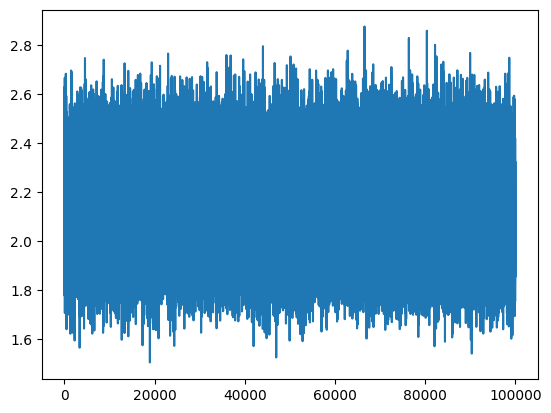

In [215]:
plt.plot(stepi, lossi)

In [ ]:
#plotting the effect of learning rate on loss
plt.plot(lri, lossi)

In [ ]:
# ^ tells us that a learning rate exponent around [-.75,-1] is good, at the minimum of the parabola-ish shape
# but when model is plateauing with learning rate, people like to decrease the learning rate as it gets 
# closer to optimized, about 1/10th of the rate, called learning rate decay

In [216]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1,60) @ W1 + b1)
logits = h @ W2 + b2
# also index into Y using same ix as used to index into X
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1675, grad_fn=<NllLossBackward0>)

In [217]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1,60) @ W1 + b1)
logits = h @ W2 + b2
# also index into Y using same ix as used to index into X
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1272, grad_fn=<NllLossBackward0>)

In [ ]:
# as paramters get larger, it is more likely for model to overfit data aka just memorize completely
# what its training on, so in industry dataset is generally split up into 3 splits:
# training split, dev/validation split, test split
# 80%, 10%, 10%
# training split used to train parameters, dev/validation split used to train hyper parameters(size of layers, size of embeddings),
# test used to evaluate performance of model, use test split sparingly, so you dont overfit to the test as well
### I am creating these splits in the cell below the original build dataset cell, in build_dataset function

In [221]:
# sample from model

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        # get embeddings? 
        emb = C[torch.tensor([context])] # embeddings for everything in current context
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift context to the right
        context = context[1:] + [ix]
        out.append(itos[ix])
        # if reach end character, break
        if ix == 0:
            break
            
    print(''.join(out))

raza.
nani.
amiillen.
zhay.
avasi.
siam.
sisha.
weofo.
zedyn.
damadahron.
kaelah.
lolah.
zaice.
jayan.
jannadary.
lhriko.
laelo.
cavyahell.
amiri.
saiten.
